# Sztuczne sieci neuronowe

Implementacja perceptronu wielowarstwowego oraz algorytmu optymalizacji gradientowej (funkcja aktywacji ReLU) z algorytmem propagacji wstecznej. 

Perceptron wielowarstwowy został wytrenowany do klasyfikacji zbioru danych `wine` (https://archive.ics.uci.edu/ml/datasets/wine)

In [1]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from typing import List
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from functools import partial
from multiprocessing import Pool
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
def one_hot(y, num_classes):
    '''
    returns a bool matrix such as ret[i][j] = 1 iff y[i] = j, 0 otherwise
    '''
    ret_y = np.zeros((y.shape[0], num_classes), dtype=bool)
    ret_y[range(y.shape[0]), y] = 1
    return ret_y

In [3]:
class MLP:
    def __init__(self, input_size: int, hidden_sizes: List[int], output_size: int, 
                 num_epochs: int, batch_size: int, learning_rate: float, random_seed: int=0):
        self.random_state = np.random.RandomState(random_seed)
        
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        self.scaler = StandardScaler()

        self.weights = []
        self.biases = []

        for size, next_size in zip([input_size, *hidden_sizes], [*hidden_sizes, output_size]):
            bound = 1 / size ** 0.5
            self.weights.append(self.random_state.uniform(-bound, bound, size=(size, next_size)))
            self.biases.append(self.random_state.uniform(-bound, bound, size=(1, next_size)))


    def _forward(self, x, return_intermediate_features=False):
        '''
        forward pass algorithm iterates through weights and biases, adds to features list pre-linear features and
        post-linear features, then calculates the x value and sets post-linear features
        x -- scaled np.array of shape (num_samples, num_features)
        '''
        if return_intermediate_features:
            features = []

        for i, (weight, bias) in enumerate(zip(self.weights, self.biases)):
            if return_intermediate_features:
                features.append([x, None])  # (pre-linear features, post-linear features)

            x = x @ weight + bias

            if return_intermediate_features:
                features[-1][1] = x
            
            if i != len(self.weights) - 1: 
                x = x.clip(min=0)  # ReLU activation 

        if return_intermediate_features:
            return x, features
        return x


    def _backward(self, grad, features):
        '''
        backward propagation algorithm 
        grad -- gradient loss on logits
        returns a list [(weight gradient, bias gradient)]
        '''
        res = []

        for i, (weight, bias, feat) in enumerate(zip(self.weights[::-1], self.biases[::-1], features[::-1])):
            if i != 0:
                grad = grad * (feat[1] > 0) #backward of ReLu function 
            res.append((
                feat[0].T @ grad, #dloss/dweights
                grad.sum(0)       #dloss/dbias
            ))
            grad = grad @ weight.T #backward through linear layer (samples) dloss/dx
        return res[::-1]


    def _loss_with_gradient(self, logits, y):
        '''
        y -- class (num_samples)
        Commentary functions check gradient dimensions, then calculates grad_loss_logits using
        steps and chain rule.
        Returns (loss value, logits gradient)
        '''
        # MSE
        # diff = logits - y
        # diff2 = diff ** 2
        # diff2sum = diff2.sum(1)
        # loss = diff2sum.mean()

        # grad_loss_diff2sum = np.zeros_like(diff2sum) + (1 / len(diff2sum))
        # grad_diff2sum_diff2 = np.array(
        #         [[[i == x
        #             for y in range(diff2.shape[1])]
        #           for x in range(diff2.shape[0])]
        #          for i in range(diff2sum.shape[0])],
        #         dtype=diff2.dtype)
        # grad_diff2_diff = np.array(
        #         [[[[2 * diff[x, y] if x == i and y == j else 0
        #             for y in range(diff.shape[1])]
        #            for x in range(diff.shape[0])]
        #           for j in range(diff2.shape[1])]
        #          for i in range(diff2.shape[0])],
        #         dtype=diff.dtype)
        # grad_diff_logits = np.array(
        #         [[[[(x == i and y == j)
        #             for y in range(logits.shape[1])]
        #            for x in range(logits.shape[0])]
        #           for j in range(diff.shape[1])]
        #          for i in range(diff.shape[0])],
        #         dtype=logits.dtype)

        # grad_loss_diff2 = np.tensordot(grad_loss_diff2sum, grad_diff2sum_diff2, axes=len(diff2sum.shape))
        # grad_loss_diff = np.tensordot(grad_loss_diff2, grad_diff2_diff, axes=len(diff2.shape))
        # grad_loss_logits = np.tensordot(grad_loss_diff, grad_diff_logits, axes=len(diff.shape))
        # return loss, grad_loss_logits
        diff = logits - one_hot(y, self.output_size)
        loss = (diff ** 2).sum(1).mean()
        grad_loss_logits = 2 * diff / diff.shape[0]
        return loss, grad_loss_logits

    def _update_weights(self, gradients):
        '''
        gradients -- a list [(weight gradient, bias gradient)] for every layer
        Updates weights and biases using SGD algorithm
        '''
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients[i][0]
            self.biases[i] -= self.learning_rate * gradients[i][1]

    def _step(self, x, y):
        '''
        calculates forward pass on scaled features `x`, loss and accuracy value, backward pass and optimizer step
        returns loss value and accuracy
        '''
        logits, features = self._forward(x, return_intermediate_features=True)
        loss, preds_gradient = self._loss_with_gradient(logits, y)
        gradients = self._backward(preds_gradient, features)
        self._update_weights(gradients)
        return loss, (logits.argmax(1) == y).mean()

    def _train_one_epoch(self, x, y):
        '''
        Train epoch with mini-batches
        Returns lists of loss and accuracy values for every iteration
        x -- scaled features
        '''
        indices = np.arange(len(x))
        self.random_state.shuffle(indices)

        losses = []
        accs = []
        batches_num = len(x) // self.batch_size
        for i in range(batches_num):
            inds = indices[i * self.batch_size: (i + 1) * self.batch_size]
            batch_x, batch_y = x[inds], y[inds]
            loss, acc = self._step(batch_x, batch_y)
            losses.append(loss)
            accs.append(acc)

        return np.array(losses), np.array(accs)
    
    def _evaluate(self, x, y):
        '''
        Returns loss and accuracy
        '''
        logits = self._forward(x)
        return self._loss_with_gradient(logits, y)[0], (logits.argmax(1) == y).mean()

    
    def predict(self, x):
        '''
        x -- unscaled data
        '''
        return self._forward(self.scaler.transform(x)).argmax(1)

    
    def fit(self, train_x, train_y, val_x=None, val_y=None):
        '''
        Trains and validates MLP neural network.
        Returns DataFrame of train and validate subsets with metrics, values and epoches stored
        in dict.
        '''
        train_x = self.scaler.fit_transform(train_x)
        if val_x is not None:
            val_x = self.scaler.transform(val_x)
        
        res = {'metric': [], 'value': [], 'epoch': []}
        for i in range(self.num_epochs):
            losses, accs = self._train_one_epoch(train_x, train_y)
            for j, loss in enumerate(losses):
                res['metric'].append('train_loss')
                res['value'].append(loss.item())
                res['epoch'].append(i + (j + 1) / len(losses))
            for j, acc in enumerate(accs):
                res['metric'].append('train_accuracy')
                res['value'].append(acc.item())
                res['epoch'].append(i + (j + 1) / len(accs))

            if val_x is not None:
                val_loss, val_acc = self._evaluate(val_x, val_y)
                res['metric'].append('val_loss')
                res['value'].append(val_loss.item())
                res['epoch'].append(i + 1)

                res['metric'].append('val_accuracy')
                res['value'].append(val_acc.item())
                res['epoch'].append(i + 1)
        return pd.DataFrame.from_dict(res)

In [12]:
def load_data():
    '''
    Loads data and splits them to X and Y
    '''
    data = load_wine()
    return data['data'], data['target']
    
def display_plot(summary, title):
    '''
    Displays two plots with metrics: train_accuracy, train_loss, val_accuracy, val_loss for
    each calculates a value of loss function and displays it for epochs.
    '''
    plt.figure(figsize=(20, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    sns.lineplot(summary[['loss' in m for m in summary.metric]], x='epoch', y='value', hue='metric', errorbar='sd')
    plt.subplot(1, 2, 2)
    sns.lineplot(summary[['accuracy' in m for m in summary.metric]], x='epoch', y='value', hue='metric', errorbar='sd')
    plt.show()

def evaluate_model(X, Y, model_args, n_splits=5, verbose=True):
    '''
    Main evaluate model function, uses CROSS-VALIDATE algorithm and fits model,
    displays plot according to fitted model, finally returns accuracy
    '''
    num_classes = Y.max() + 1

    preds = []
    gt = []
    summaries = []
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=model_args.get('random_seed', 0))
    for i, (train_indices, val_indices) in enumerate(skf.split(X, Y)):
        model = MLP(input_size=X.shape[1], output_size=num_classes, **model_args)
        summary = model.fit(X[train_indices], Y[train_indices], X[val_indices], Y[val_indices])
        summaries.append(summary)
        preds.append(model.predict(X[val_indices]))
        gt.append(Y[val_indices])

        if verbose:
            display_plot(summary, f'CV {i + 1} / {n_splits}')
    summaries = pd.concat(summaries)

    if verbose:
        display_plot(summaries, f'all CV')

    preds = np.concatenate(preds)
    gt = np.concatenate(gt)
    if verbose:
        ConfusionMatrixDisplay.from_predictions(gt, preds, normalize="all")
    return (preds == gt).mean()


In [5]:
def random_search(X, Y, iterations, reps, pool=__builtins__):
    '''
    performs a random search to find best hyperparameters for the model.
    `iterations` different hyperparameters are randomized, and evaluated `reps` times (with different random seeds)
    returns best hyperparameters and accuracy
    '''
    args = [
        dict(learning_rate=10 ** np.random.normal(-1.5, 1),
             hidden_sizes=[round(2 ** np.random.randint(0, 8)) for _ in range(np.random.randint(0, 4))],
             batch_size=np.random.randint(1, 32),
             num_epochs=np.random.randint(1, 10))
        for i in range(iterations)
    ]
    accs = np.array([
        pool.map(partial(evaluate_model, X, Y, verbose=False), [a | {'random_seed': j} for a in args])
        for j in range(reps)
    ])
    accs = accs.mean(0)
    i = accs.argmax()
    return args[i], accs[i]

In [6]:
def plot_factor_dependency(name, values, default_args, reps=5, xlog=False, pool=__builtins__, show=True):

    res = {name: [], 'accuracy': []}
    for arg in values:
        args = default_args.copy()
        args[name] = arg
        
        for accuracy in pool.map(partial(evaluate_model, X_nontest, y_nontest, verbose=False), [args | {'random_seed': i} for i in range(reps)]):
            if isinstance(arg, float):
                res[name].append(arg)
            else:
                res[name].append(str(arg))
            res['accuracy'].append(accuracy)

    
    df = pd.DataFrame.from_dict(res) 
    sns.lineplot(data=df, x=name, y='accuracy', errorbar='sd')
    sns.scatterplot(data=df, x=name, y='accuracy', alpha=0.05)
    if xlog:
        plt.xscale('log')
    
    #Rysowanie poziomej najlepszej linnii
    aggregated_df = df.groupby(name).mean().reset_index()
    row = aggregated_df[aggregated_df.accuracy == aggregated_df.accuracy.max()].iloc[0]
    plt.axvline(row[name], linestyle='dashed', color='r')
    plt.title(f'{name}\nfound best {name}={row[name]} with average accuracy {row["accuracy"] * 100:.2f}%')
    if show:
        plt.show()

## Test na funkcji xor

In [64]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
Y = np.array([0, 1, 1, 0])

model = MLP(input_size=2, hidden_sizes=[4], output_size=2, learning_rate=0.01, num_epochs=1000, batch_size=2)
model.fit(X, Y)
for x, y, pred in zip(X, Y, model.predict(X)):
    print(f'x={x}, y={y}, model_prediction={pred}, {"OK" if pred == y else "WRONG"}')

x=[0. 0.], y=0, model_prediction=0, OK
x=[0. 1.], y=1, model_prediction=1, OK
x=[1. 0.], y=1, model_prediction=1, OK
x=[1. 1.], y=0, model_prediction=0, OK


Model na funkcji xor był w stanie prawidłowo się nauczyć.

## Podział na dane testowe i treningowo-walidacyjne (do CV)

In [7]:
X, Y = load_data()
X_nontest, X_test, y_nontest, y_test = train_test_split(X, Y, test_size=0.3, random_state=43, stratify=Y)

In [8]:
THREADS = 4

## **Szukanie najlepszych hiperparametrów oraz wykresy**

Losowanie 1000 hiperparametrów i wybieranie tego najlepszego, dla każdego wykonywanie walidacji krzyżowej 64 razy z 
różnymi random seed'ami.

In [9]:
%%time
with Pool(THREADS) as pool:
    best_args, best_accuracy = random_search(X_nontest, y_nontest, iterations=1000, reps=64, pool=pool)
print(best_args)
print('accuracy:', best_accuracy)

{'learning_rate': 0.1842215490885833, 'hidden_sizes': [128, 64, 64], 'batch_size': 15, 'num_epochs': 8}
accuracy: 0.9789566532258069
CPU times: user 3.53 s, sys: 847 ms, total: 4.37 s
Wall time: 13min 53s


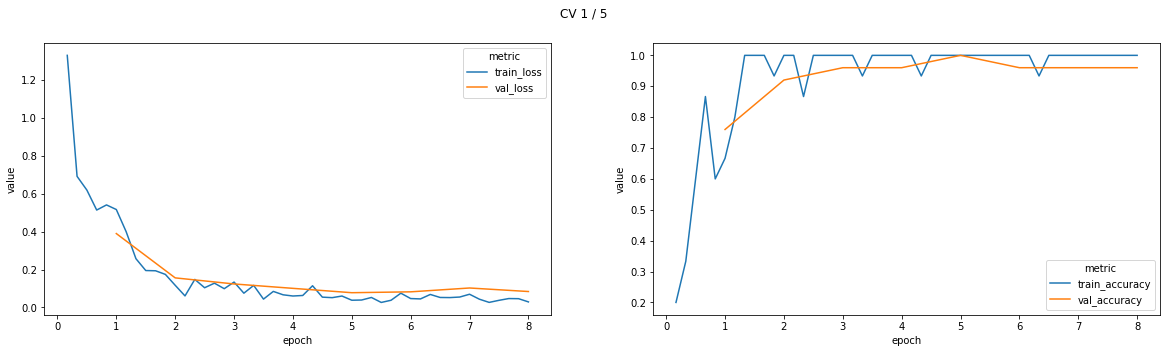

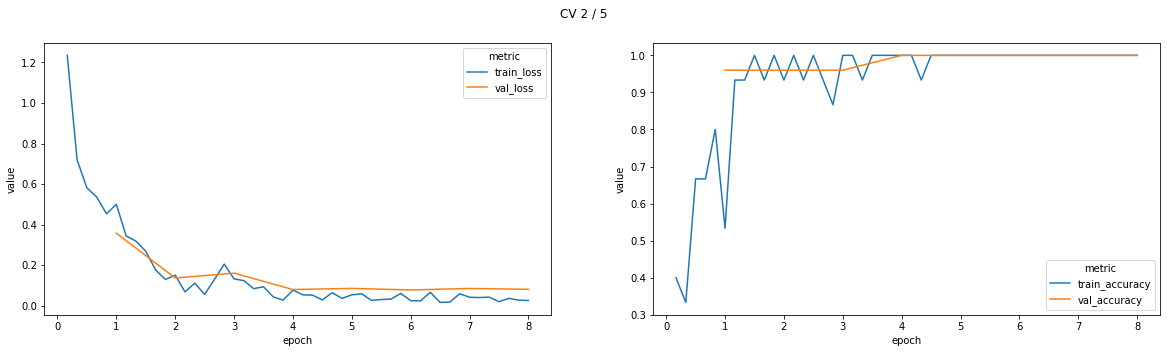

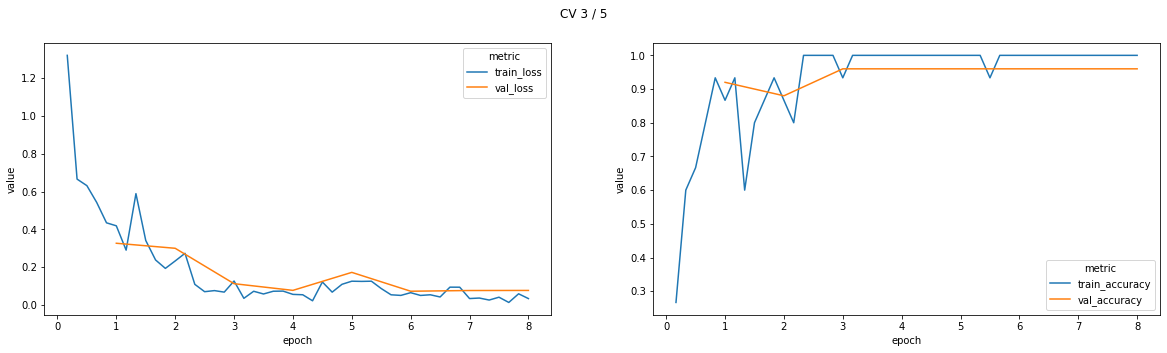

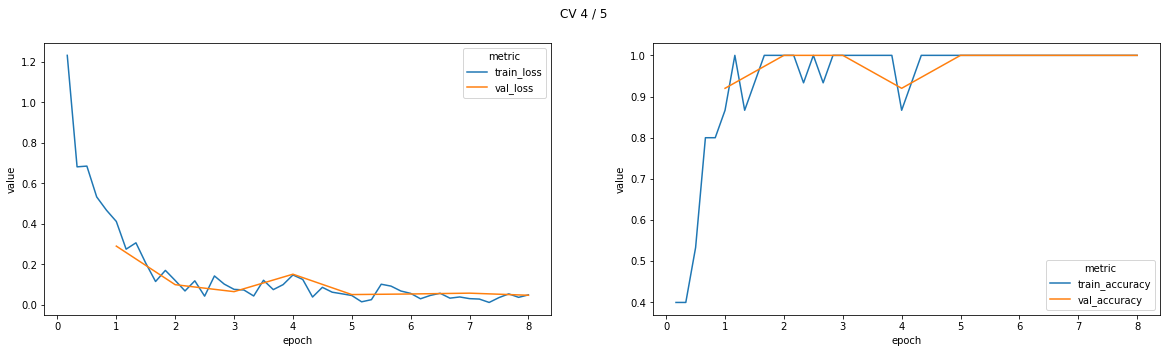

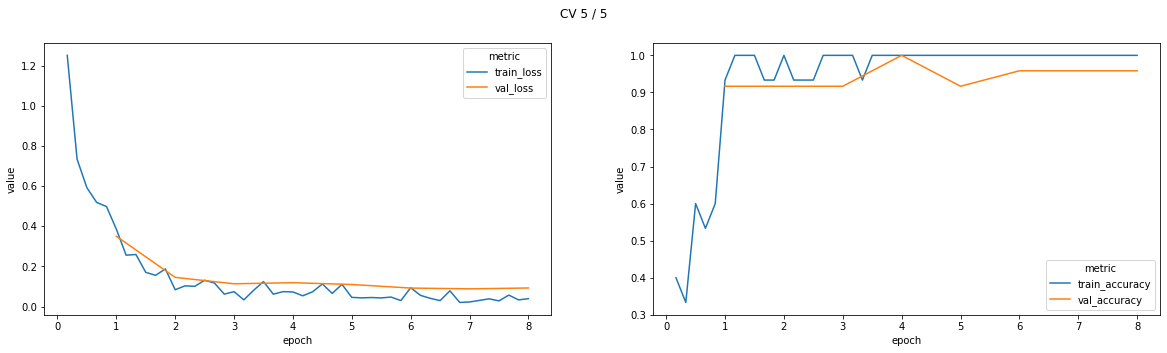

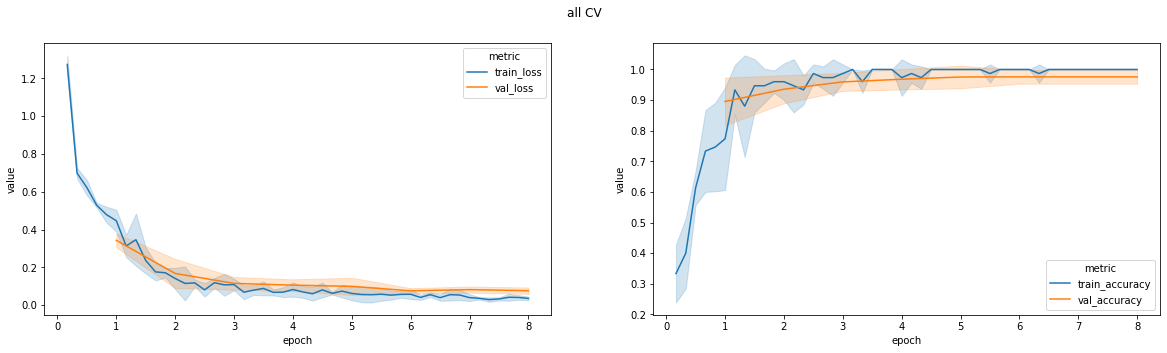

0.9758064516129032

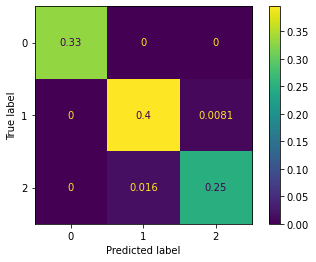

In [13]:
evaluate_model(X_nontest, y_nontest, best_args)

## **Wnioski**

Model osiąga duże accuracy o wartości 97,6% (w szczególności nigdy nie myli sie co do klasy '0', i ta klasa nie jest mylona).
Jedyna zauważalna misklasyfikacja jest pomiędzy klasą '1', a '2'. Na wykresach nie jest widoczne zjawisko overfittingu.

Zaimplementowany model zbiega się zgodnie z oczekiwaniami, wraz z liczbą iteracji/liczbą epok wartość accuracy wzrasta, zarówno dla danych
trenujacych jak i walidacyjnych. W przypadku funkcji straty wraz ze zwiększaniem iteracji jej wartość maleje dla danych trenujących jak i walidacyjnych. Odchylenie standardowe dla metryki accuracy maleje wraz ze wzrostem liczby epok, stablizuje się przy trzeciej. 
Dla wykresu funkcji starty, zauważalne jest minimalne odchylenie dla danych trenujących jak i walidacyjnych, które potem zanika.

## Dodatkowe wykresy

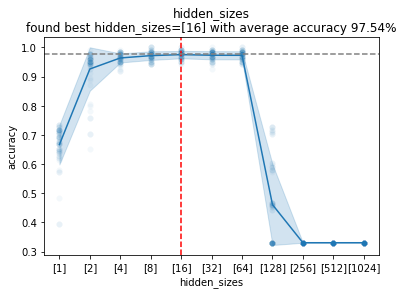

In [18]:
with Pool(THREADS) as pool:
    plot_factor_dependency('hidden_sizes', [[2 ** i] for i in range(0, 11)], best_args, reps=64, pool=pool, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

Dla hiperparametru ilości neuronów w warstwie ukrytej, zakładajać że wartstwa jest tylko jedna, widać na początku wzrost, a nastepnie 
gwałtowny spadek
spowodowane jest to, że model rozbiega sie przez wysoki learning rate. 

Żeby to pokazać przedstawie to ze zmniejszonym learning rate (relacja bedzie monotoniczna). 

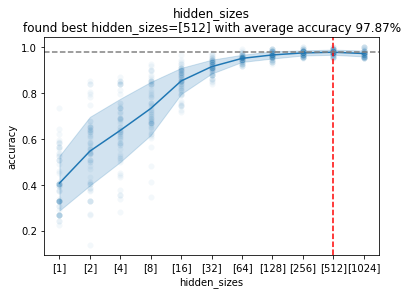

In [25]:
with Pool(THREADS) as pool:
    plot_factor_dependency('hidden_sizes', [[2 ** i] for i in range(0, 11)], best_args | {'learning_rate': 0.01}, reps=64, pool=pool, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

Dla małych wartości neuronów w ukrytych warstwach model nie zbiega sie dostatecznie szybko (mozna to analogicznie 
przedstawic poprzez zwiększenie liczby epok)

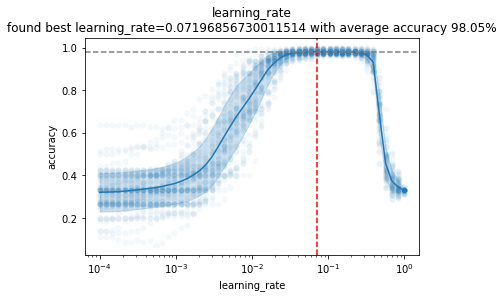

In [26]:
with Pool(THREADS) as pool:
    plot_factor_dependency('learning_rate', np.logspace(-4, 0, base=10, num=50), best_args, reps=64, pool=pool, xlog=True, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

Wykres ma charakter bitoniczny(rośnie-maleje), początkowo learning rate jest za mały, aby sie zbiegnąc, a potem jest za duży i
rozbiega się. Początkowo odchylenie jest duże (znacząco zależy od inicjalizacji wag), a potem maleje. Najlepsza wartośc learning rate dla
danych wczesniejszych hiperparametrów jest w zakresie 0,02 do 0,2.

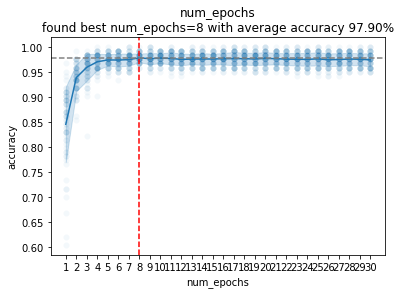

In [20]:
with Pool(THREADS) as pool:
    plot_factor_dependency('num_epochs', np.arange(1, 31), best_args, reps=64, pool=pool, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

Jak widać po około 6 epokach (dla konkretnych wcześniej obliczonych hiperparametrów) model stablizuje się.

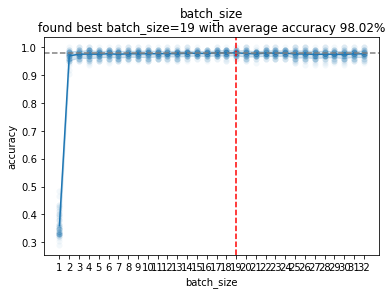

In [21]:
with Pool(THREADS) as pool:
    plot_factor_dependency('batch_size', np.arange(1, 33), best_args, reps=64, pool=pool, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

Wielkośc batch_size nie ma znaczenia, stała wartość od wielkości 2, najlepsza uśredniona wartość accuracy jest dla wielkosci batch size 
równego 19. Dla batch size równego 1 accuracy jest mniejsze, ponieważ ponownie model sie rozbiega, jest to spowodowane tym że tak dla małego 
batch size gradient wag jest niestablilny. Pokazane na rysunku poniżej, że dla zmniejszonego learning rate nie widać wyraznie różnicy między 
batch size równym 1, a innymi wartościami.

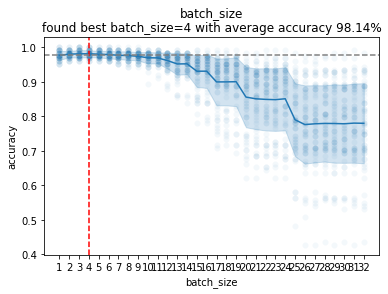

In [28]:
with Pool(THREADS) as pool:
    plot_factor_dependency('batch_size', np.arange(1, 33), best_args | {'learning_rate': 0.02}, reps=64, pool=pool, show=False)
    plt.axhline(best_accuracy, color='gray', linestyle='dashed')

Dla zmniejszonego learning rate, dla większych batch size model nie zbiega sie wystarczająco szybko (liczba treningowych iteracji jest odwrotnie proporcjonalna do batch size).

# Testowanie modelu na zbiorze testowym

In [29]:
model = MLP(input_size=X.shape[1], output_size=Y.max() + 1, **best_args)
model.fit(X_nontest, y_nontest)
preds = model.predict(X_test)

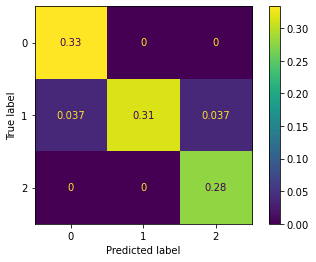

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize="all")

In [31]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.81      0.89        21
           2       0.88      1.00      0.94        15

    accuracy                           0.93        54
   macro avg       0.93      0.94      0.93        54
weighted avg       0.93      0.93      0.92        54



Model osiągnął wartość accuracy 93% (co oznacza, że zle sklasyfikował tylko 4 próbki/sample, w zbiorze testowym mamy 54 sample)